In [20]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-dark-palette")  # seaborn style
plt.rcParams.update(
    {
        "figure.figsize": (12, 6),  # set default figure size
        "axes.labelsize": 16,  # set default label size
        "axes.grid": True,  # enable grid by default
        
        "xtick.labelsize": 14,  # set default tick label size
        "ytick.labelsize": 14,  # set default tick label size
        "axes.titlesize": 18,  # set default title size
        "legend.fontsize": 16,  # set default legend font size
        "lines.linewidth": 4,  # set default line width
        "text.usetex": False,  # use LaTeX
        "font.family": "serif",  # use a serif font
        "image.cmap": "magma",  # set default colormap
    }
)

from rich.console import Console
from rich.style import Style

base_style = Style(color="white", frame=True, bold=True)
console = Console(style=base_style)

from pathlib import Path
plots_dir = Path("../plots")

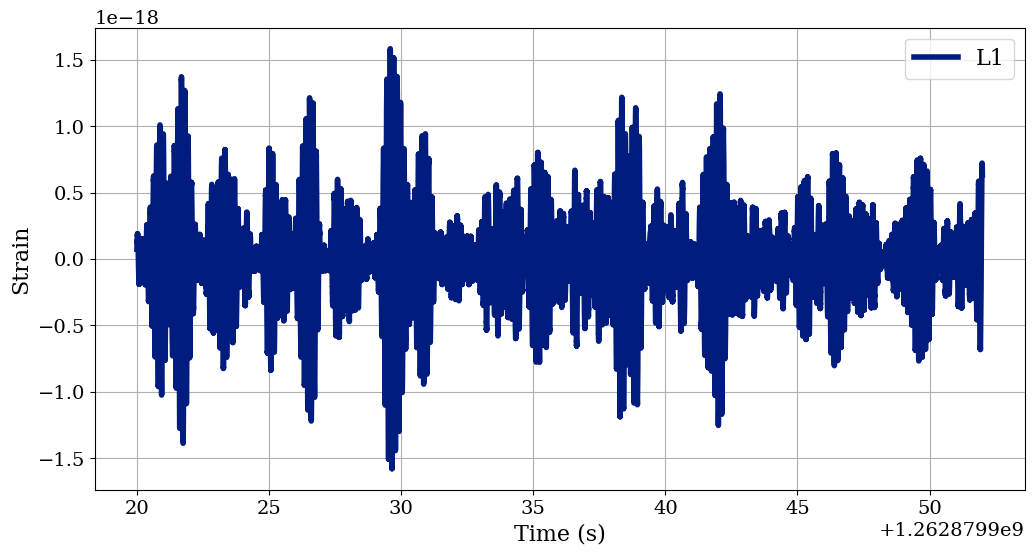

In [22]:

from pycbc import catalog
m = catalog.Merger("GW200112_155838-v1", source='gwtc-3')

ts_liv = m.strain('L1')

plt.plot(ts_liv.sample_times, ts_liv, label="L1")
plt.legend()
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.savefig(plots_dir / "gw200112_strain_l1.pdf", format='pdf')
plt.show()

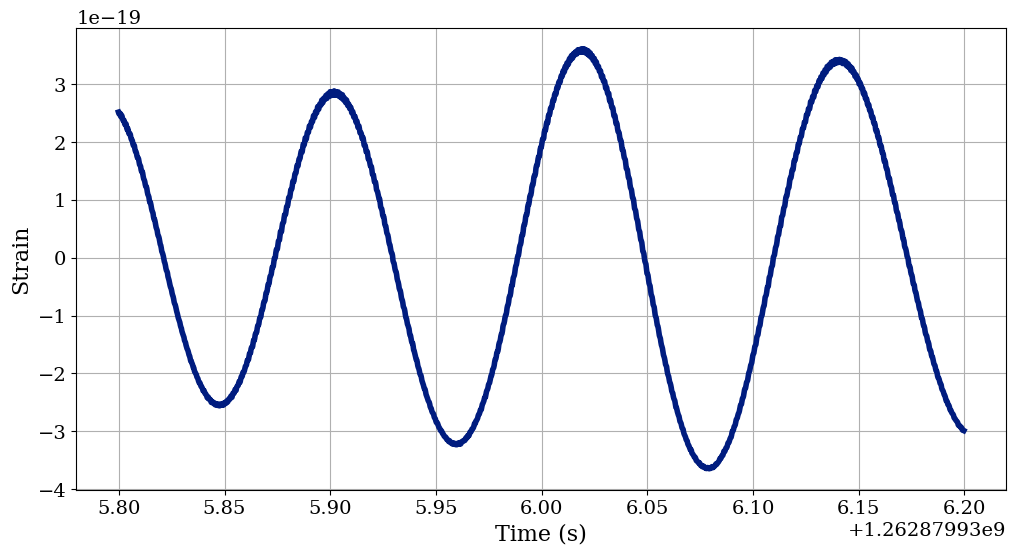

In [23]:
merge_window = ts_liv.time_slice(m.time - 0.2, m.time + 0.2 )
plt.plot(merge_window.sample_times, merge_window)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.savefig(plots_dir / "gw200112_strain_l1_zoom.pdf", format='pdf')
plt.show()

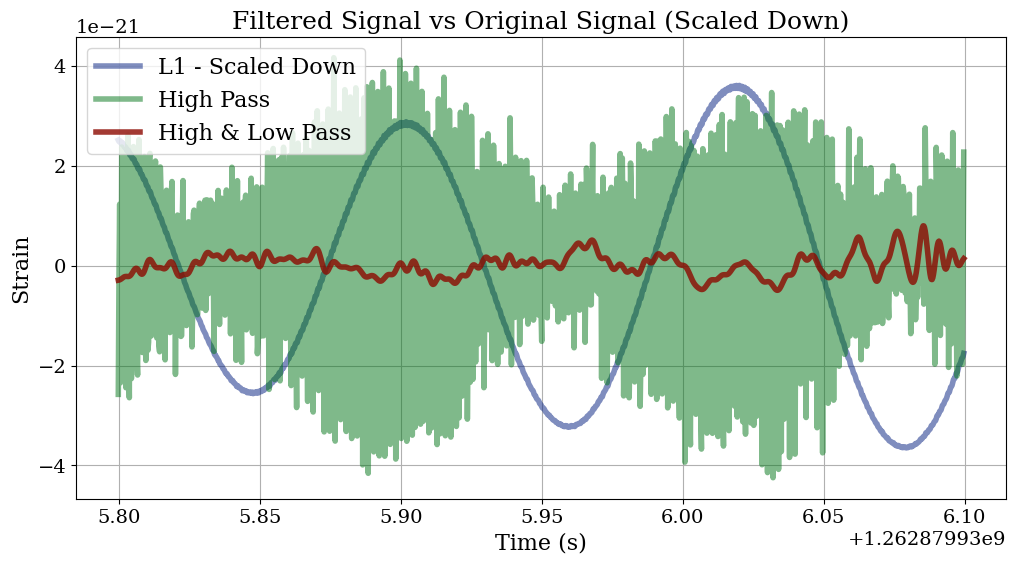

In [24]:

highpass = ts_liv.highpass_fir(30, 512)
lowpass = highpass.lowpass_fir(250, 512) # two more freq filters


# zoom in on event
event = lowpass.time_slice(m.time -0.2, m.time + 0.1)
plt.plot(event.sample_times, ts_liv.time_slice(m.time -0.2, m.time + 0.1) / 100, label="L1 - Scaled Down", alpha=0.5)
plt.plot(event.sample_times, highpass.time_slice(m.time -0.2, m.time + 0.1), label="High Pass", alpha=0.5)
plt.plot(event.sample_times, event, label="High & Low Pass", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Filtered Signal vs Original Signal (Scaled Down)')
plt.legend()
plt.savefig(plots_dir / "gw200112_filtered_signals.pdf", format='pdf')
plt.show()

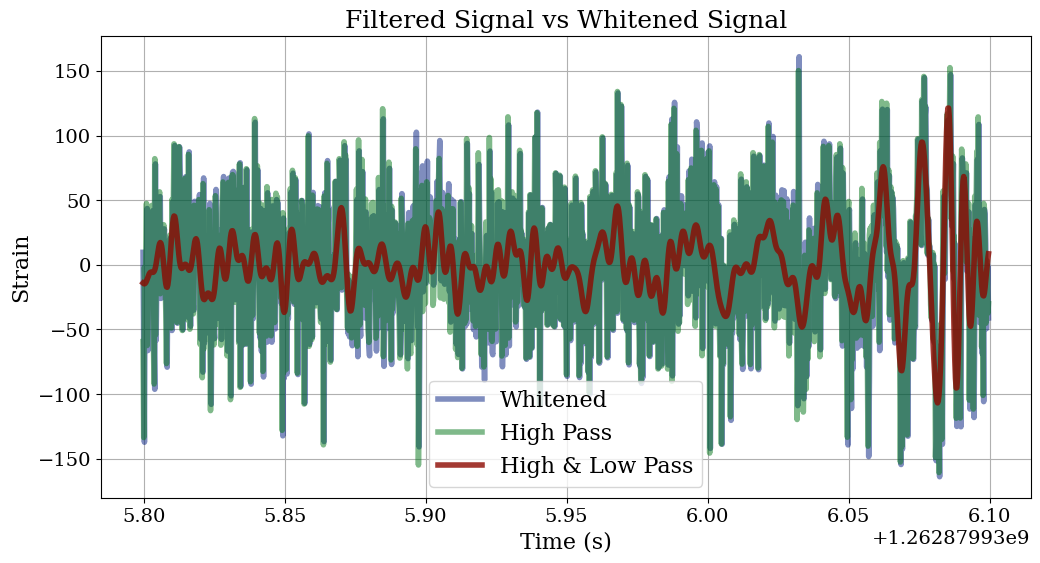

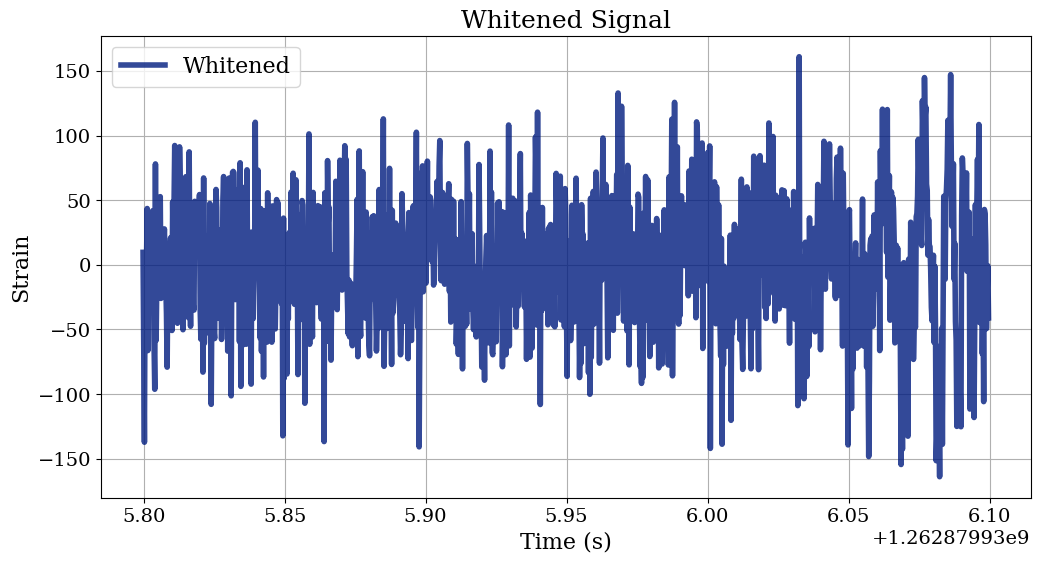

In [26]:
whitened = ts_liv.whiten(4, 4) # Flatten Freq Response of PSD
highpass = whitened.highpass_fir(30, 512)
lowpass = highpass.lowpass_fir(250, 512) # two more freq filters


# zoom in on event
event = lowpass.time_slice(m.time -0.2, m.time + 0.1)
plt.plot(event.sample_times, whitened.time_slice(m.time -0.2, m.time + 0.1), label="Whitened", alpha=0.5)
plt.plot(event.sample_times, highpass.time_slice(m.time -0.2, m.time + 0.1), label="High Pass", alpha=0.5)
plt.plot(event.sample_times, event, label="High & Low Pass", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Filtered Signal vs Whitened Signal')
plt.legend()
plt.savefig(plots_dir / "gw200112_whitened_filtered_signals.pdf", format='pdf')
plt.show()

# just whitened
event = whitened.time_slice(m.time -0.2, m.time + 0.1)
plt.plot(event.sample_times, event, label="Whitened", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Whitened Signal')
plt.legend()
plt.savefig(plots_dir / "gw200112_whitened_signal.pdf", format='pdf')
plt.show()

## Whitened Signal

In [ ]:
import numpy as np
from rich.progress import track
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.tmpltbank import interpolate_psd
from functools import lru_cache
from pycbc.types import TimeSeries, FrequencySeries


def fir_filter(signal, lowpass, highpass):
    """Applies FIR highpass and lowpass filters to the input signal."""
     
    @lru_cache(maxsize=None) # Cache results for performance
    def highpass_fir(cutoff):
        return signal.highpass_fir(cutoff, 1024)
    
    filtered_signal = highpass_fir(highpass)
    filtered_signal = filtered_signal.lowpass_fir(lowpass, 1024)
    
    # Ensure filtered signal is cropped to valid time range after filtering
    # FIR filters may shift the valid time range, so we use the filtered signal's own time range
    valid_start = max(signal.start_time, filtered_signal.start_time)
    valid_end = min(signal.end_time, filtered_signal.end_time)
    filtered_signal = filtered_signal.time_slice(valid_start, valid_end)
    return filtered_signal

def snr(raw_signal: TimeSeries, filtered_signal: TimeSeries):
    """Calculates the signal-to-noise ratio (SNR) between the raw and filtered signals."""
    # Ensure both signals are aligned in time
    raw_signal = raw_signal.time_slice(filtered_signal.start_time, filtered_signal.end_time)
    noise = raw_signal - filtered_signal 
    signal_power = np.asarray(filtered_signal ** 2).mean()
    noise_power = np.asarray(noise ** 2).mean()
    return 10 * np.log10(signal_power / noise_power)

def snr_template(psd, filtered_signal: TimeSeries):
    """Calculates the SNR of the filtered signal against a given template."""
    
    template, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=m.mass1, mass2=m.mass2,
                              delta_f=filtered_signal.delta_f, f_lower=20, f_final=2048)
    # Cut off last frequency for template and psd to match lengths
    template = template[:len(filtered_signal)]
    sample_freq, psd_fit = interpolate_psd(psd.sample_frequencies, psd, filtered_signal.delta_f)
    psd_fit = FrequencySeries(psd_fit, delta_f=filtered_signal.delta_f)[:len(filtered_signal)]
    
    snr = matched_filter(template, filtered_signal, psd=psd_fit, low_frequency_cutoff=20)
    peak = abs(snr).max()
    return 10 * np.log10(peak)

f_range = np.linspace(1, 512, 40)
snr_results = np.zeros((len(f_range), len(f_range)))
whitened = ts_liv.whiten(4, 4).time_slice(m.time - 1, m.time + 1) # Flatten Freq Response of PSD
psd = whitened.filter_psd(0.125, whitened.delta_f, flow=20)
USE_TEMPLATE_SNR = True


def trial(base, band): 
    """Runs a trial of FIR filtering and SNR calculation."""
    lowpass, highpass = band
    
    if highpass >= lowpass:
        return -np.inf  # Invalid filter parameters
    
    filtered_signal = fir_filter(base, lowpass, highpass)
    if USE_TEMPLATE_SNR:
        return snr_template(psd, filtered_signal)
    else:
        return snr(base, filtered_signal)

bands_grid = np.meshgrid(f_range, f_range)
bands_1D = np.array(bands_grid).T.reshape(-1, 2)


results = [trial(whitened, band) for band in track(bands_1D, description="Calculating SNR for filter bands...")]

snr_results = np.array(results).T.reshape(len(f_range), len(f_range))




Output()

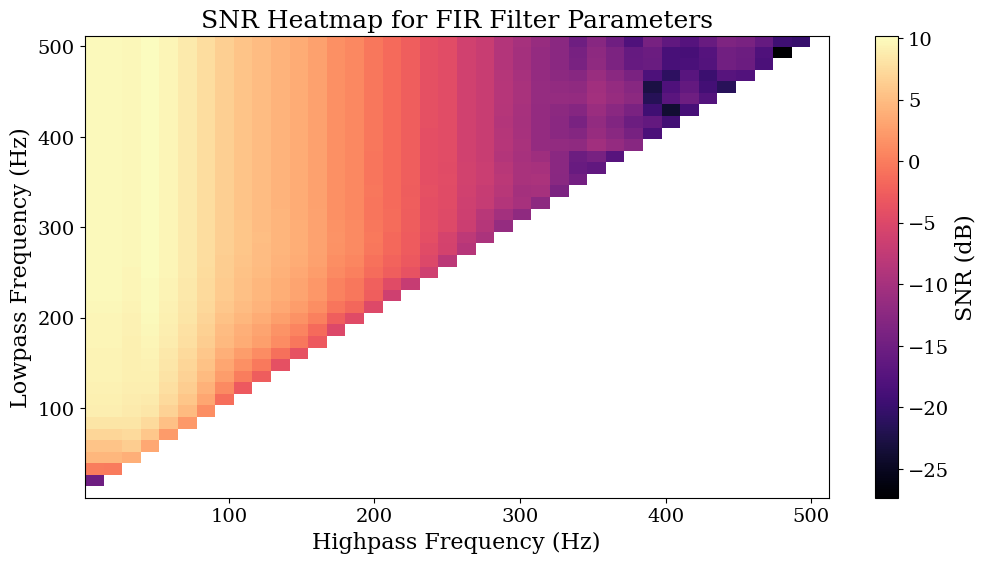

In [ ]:
plt.imshow(snr_results, extent=(f_range.min(), f_range.max(), f_range.min(), f_range.max()), origin='lower', aspect='auto')
plt.grid(False)
plt.colorbar(label='SNR (dB)')
plt.xlabel('Highpass Frequency (Hz)')
plt.ylabel('Lowpass Frequency (Hz)')
plt.title('SNR Heatmap for FIR Filter Parameters')
plt.savefig(plots_dir / 'fir_filter_snr_heatmap.pdf', dpi=300, format='pdf')
plt.show()

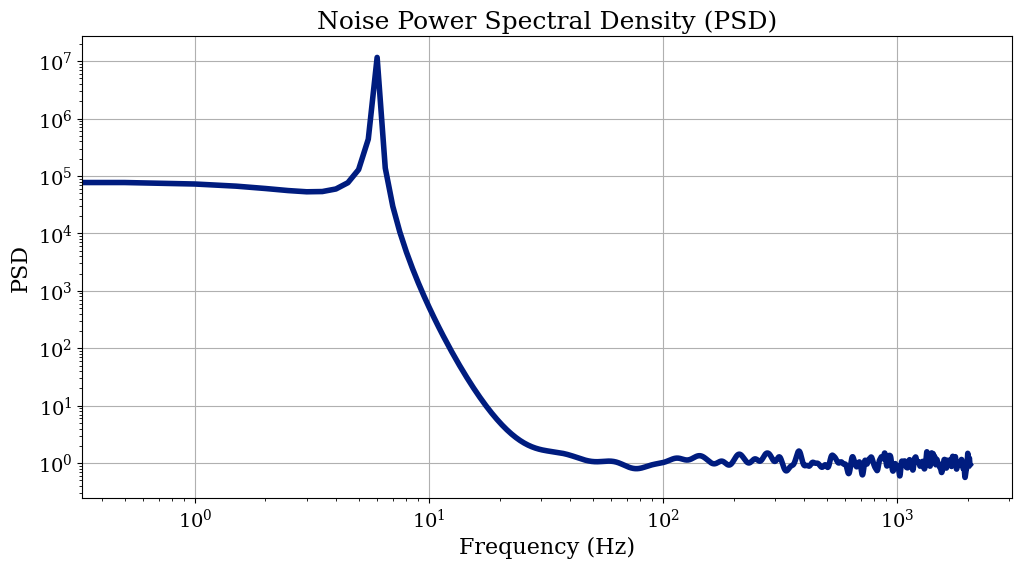

/home/teunb/Assignments/gravitational-waves/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/teunb/Assignments/gravitational-waves/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


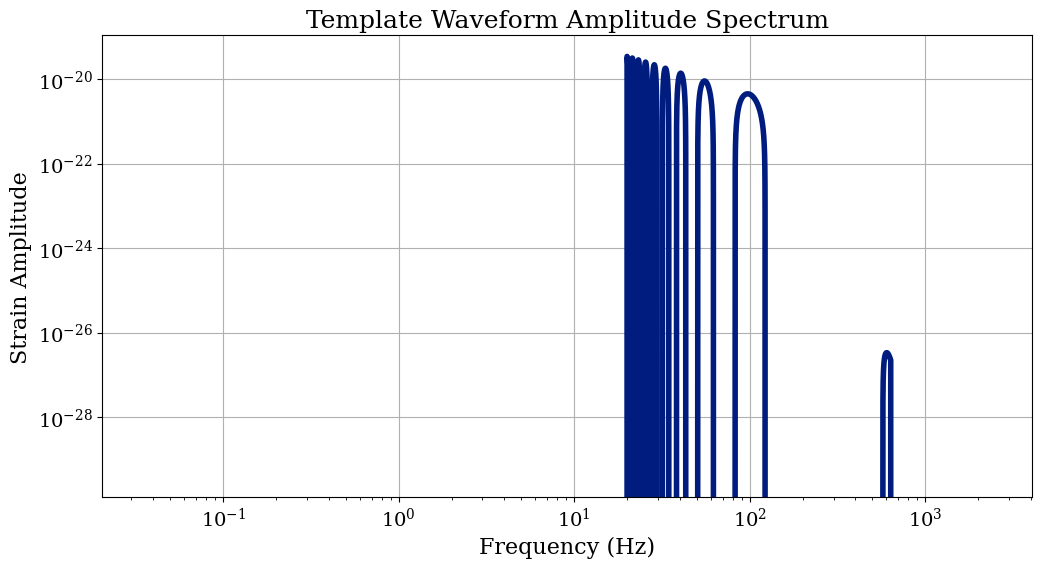

In [27]:
# plot psd
template, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=m.mass1, mass2=m.mass2,
                              delta_f=whitened.delta_f, f_lower=20, f_final=2048)
plt.loglog(psd.sample_frequencies, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('Noise Power Spectral Density (PSD)')
plt.savefig('../plots/gw200112_psd_noise.pdf', format='pdf')
plt.show()

plt.loglog(template.sample_frequencies, template)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain Amplitude')
plt.title('Template Waveform Amplitude Spectrum')
plt.savefig('../plots/gw200112_template_waveform.pdf', format='pdf')
plt.show()

Whitened Signal - Maximum SNR: 10.198462154079447 dB at Lowpass: 289.2564102564103 Hz, Highpass: 40.30769230769231 
Hz

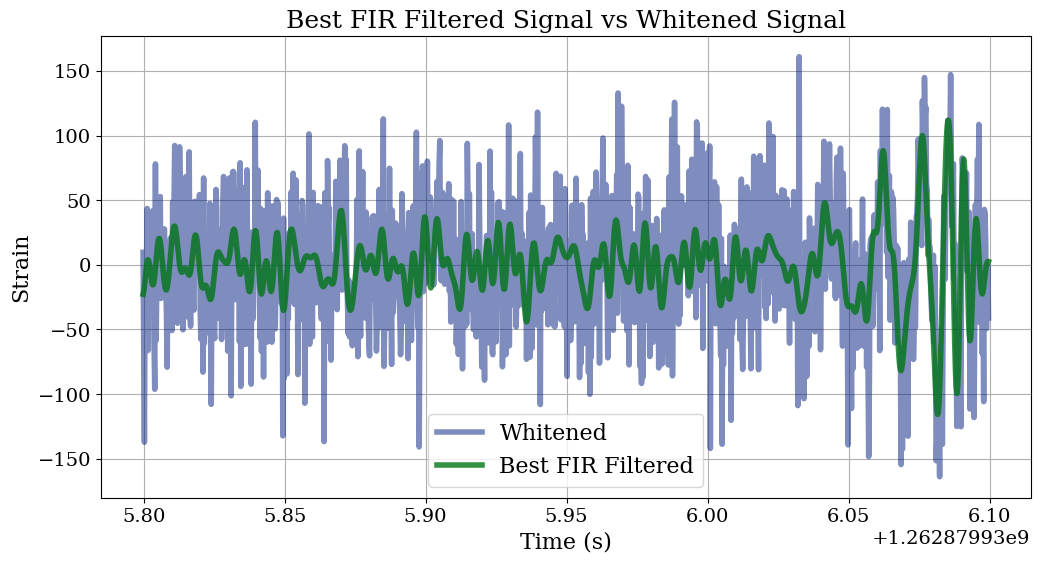

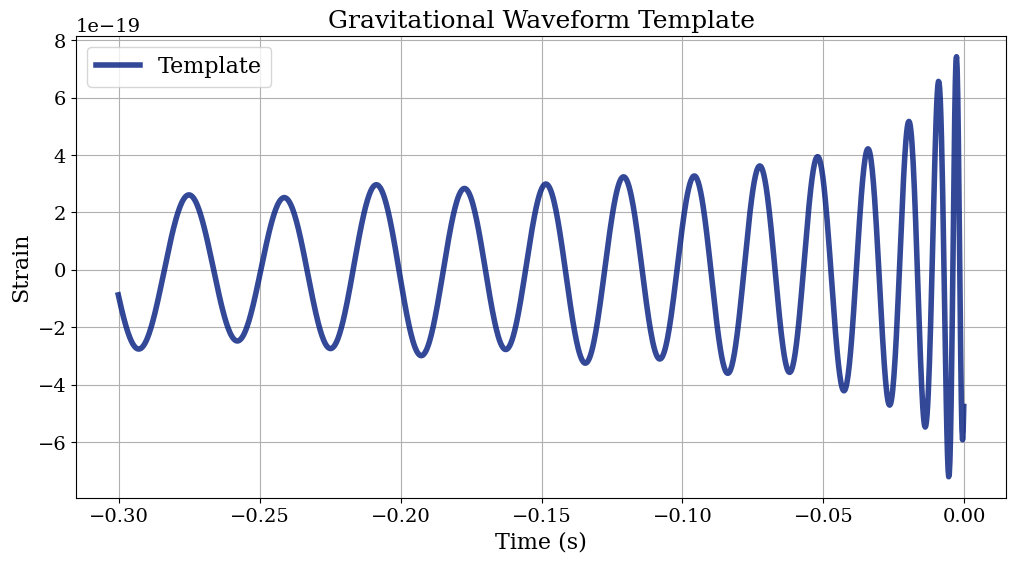

In [34]:

snr_max = np.argmax(results)
best_lowpass, best_highpass = bands_1D[snr_max]
snr_max_value = results[snr_max]
console.print(f"[bold yellow]Whitened Signal - Maximum SNR:[/bold yellow] {snr_max_value} dB at Lowpass: {best_lowpass} Hz, Highpass: {best_highpass} Hz")


# apply best filter and plot
best_filtered = fir_filter(whitened, best_lowpass, best_highpass)
event = best_filtered.time_slice(m.time -0.2, m.time + 0.1)
plt.plot(event.sample_times, whitened.time_slice(m.time -0.2, m.time + 0.1), label="Whitened", alpha=0.5)
plt.plot(event.sample_times, best_filtered.time_slice(m.time -0.2, m.time + 0.1), label="Best FIR Filtered", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Best FIR Filtered Signal vs Whitened Signal')
plt.legend()
plt.savefig(plots_dir / "gw200112_best_fir_filtered_signal.pdf", format='pdf')
plt.show()

# plot template 
template, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=m.mass1, mass2=m.mass2,
                            delta_f=whitened.delta_f, f_lower=20, f_final=2048)
template = template.to_timeseries()
event_template = template.time_slice(-0.3, 0)

plt.plot(event_template.sample_times, event_template, label="Template", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Gravitational Waveform Template')
plt.legend()
plt.savefig(plots_dir / "gw200112_waveform_template.pdf", format='pdf')
plt.show()

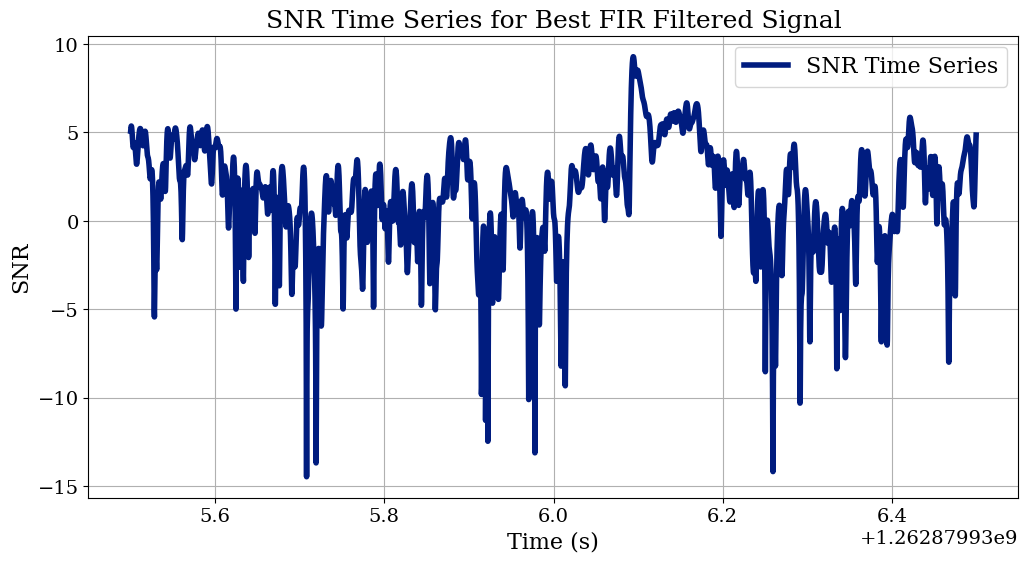

In [ ]:
# plot snr over time for best filter
snr_series = matched_filter(template, best_filtered, low_frequency_cutoff=20)
plt.plot(snr_series.sample_times, 10 * np.log10(abs(snr_series)), label="SNR Time Series")
plt.xlabel('Time (s)')
plt.ylabel('SNR')
plt.title('SNR Time Series for Best FIR Filtered Signal')
plt.legend()
plt.show()

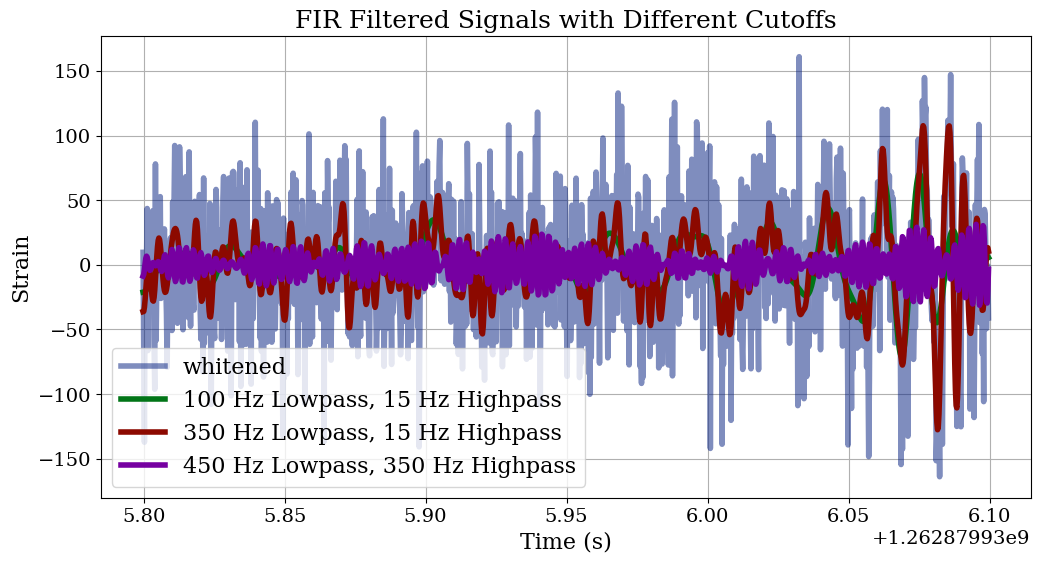

In [14]:
from pycbc.waveform import get_td_waveform
event = whitened.time_slice(m.time -0.2, m.time + 0.1)
plt.plot(event.sample_times, event, label="whitened", alpha=0.5)
plt.plot(event.sample_times, fir_filter(whitened, 100, 15).time_slice(m.time -0.2, m.time + 0.1), label="100 Hz Lowpass, 15 Hz Highpass")
plt.plot(event.sample_times, fir_filter(whitened, 350, 15).time_slice(m.time -0.2, m.time + 0.1), label="350 Hz Lowpass, 15 Hz Highpass")
plt.plot(event.sample_times, fir_filter(whitened, 450, 350).time_slice(m.time -0.2, m.time + 0.1), label="450 Hz Lowpass, 350 Hz Highpass")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('FIR Filtered Signals with Different Cutoffs')
plt.legend()
plt.show()


## Without Whitening

In [ ]:
base = ts_liv.time_slice(m.time - 1, m.time + 1)

results = [trial(whitened, band) for band in track(bands_1D, description="Recalculating SNR for filter bands...")]
unwhitened_snr_results = np.array(results).reshape(len(f_range), len(f_range))

Output()

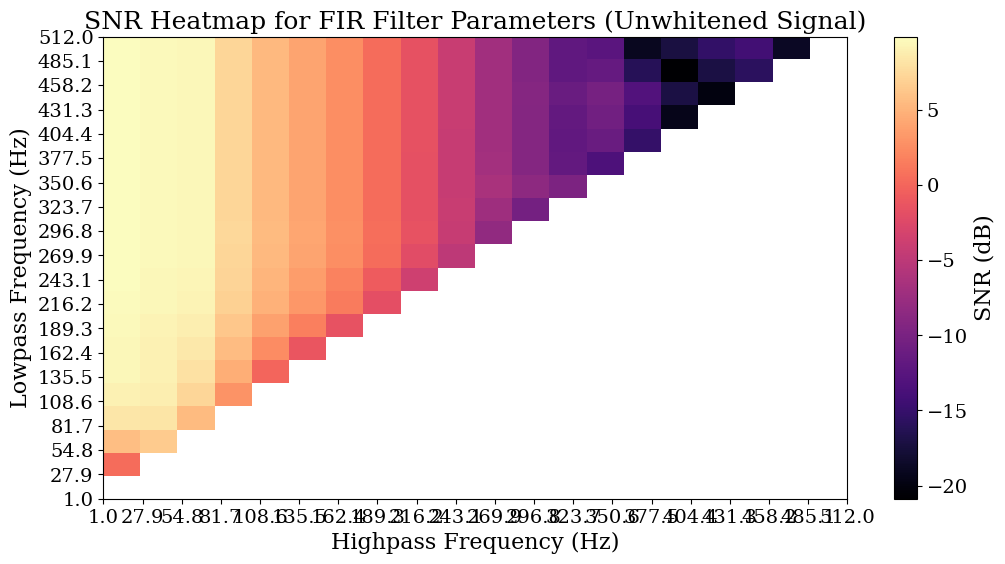

In [ ]:
plt.imshow(unwhitened_snr_results, extent=(f_range.min(), f_range.max(), f_range.min(), f_range.max()), origin='lower', aspect='auto')
plt.grid(False)
plt.colorbar(label='SNR (dB)')
plt.xlabel('Highpass Frequency (Hz)')
plt.xticks(f_range)
plt.yticks(f_range)
plt.ylabel('Lowpass Frequency (Hz)')
plt.title('SNR Heatmap for FIR Filter Parameters (Unwhitened Signal)')
plt.show()

In [15]:
# plot best filter on unwhitened signal
snr_max = np.unravel_index(np.argmax(unwhitened_snr_results), unwhitened_snr_results.shape)
snr_max_value = unwhitened_snr_results[snr_max]
console.print(f"[bold yellow]Unwhitened Signal - Maximum SNR:[/bold yellow] {snr_max_value} dB at Lowpass: {f_range[snr_max[0]]} Hz, Highpass: {f_range[snr_max[1]]} Hz")
best_lowpass = bands_grid[1][snr_max]
best_highpass = bands_grid[0][snr_max]  

plt.plot(event.sample_times, fir_filter(base, best_lowpass, best_highpass).time_slice(m.time -0.2, m.time + 0.1), label="Best FIR Filtered", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Best FIR Filtered Signal vs Unwhitened Signal')
plt.legend()
plt.show()

NameError: name 'unwhitened_snr_results' is not defined